# Configuración Inicial

## Habilitar GPU (Google Colab)

En la barra superior:

1.   Entorno de ejecución
2.   Cambiar tipo de entorno de ejecución -> GPU


## Subir *dataset* (Google Colab)

In [1]:
### QUITAR COMENTARIOS Y EJECUTAR PARA USAR EN GOOGLE COLAB ###

#from google.colab import files

#uploaded = files.upload()  # Seleccionar el archivo desde el sistema local

## Importar utilidades

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1 Procesamiento de datos

## 1.1 Carga y exploración inicial

### 1.1.1 Carga del dataset y visualización inicial

In [3]:
df = pd.read_csv('houses_balears.csv')
print("Filas originales:", len(df))

Filas originales: 24880


In [4]:
# Mostrar información básica del DataFrame
print("Filas originales:", len(df))
print("Información del DataFrame:")
print(df.info())

# Convertir columnas numéricas a su tipo apropiado
numeric_columns = ['price', 'm2_real', 'm2_useful', 'bath_num', 'room_num']

# Convertir cada columna numérica
for col in numeric_columns:
    # Identificar valores no numéricos
    non_numeric_mask = ~df[col].astype(str).str.isnumeric()
    non_numeric_count = non_numeric_mask.sum()
    print(f"Valores no numéricos en {col}:", non_numeric_count)
    
    # Convertir a numérico y marcar valores no numéricos como NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar filas con valores faltantes en price (columna crítica)
df = df.dropna(subset=['price'])
print("\nFilas después de limpiar columnas numéricas:", len(df))

Filas originales: 24880
Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24880 entries, 0 to 24879
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ad_description     24356 non-null  object
 1   ad_last_update     24880 non-null  object
 2   air_conditioner    24880 non-null  object
 3   balcony            24880 non-null  object
 4   bath_num           24880 non-null  object
 5   built_in_wardrobe  24880 non-null  object
 6   chimney            24880 non-null  object
 7   condition          18204 non-null  object
 8   construct_date     10314 non-null  object
 9   energetic_certif   18860 non-null  object
 10  floor              16615 non-null  object
 11  garage             11087 non-null  object
 12  garden             24880 non-null  object
 13  ground_size        58 non-null     object
 14  heating            6349 non-null   object
 15  house_id           24880 non-null  o

In [5]:
print("\nValores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
ad_description         524
ad_last_update           0
air_conditioner          0
balcony                  0
bath_num               193
built_in_wardrobe        0
chimney                  0
condition             6676
construct_date       14566
energetic_certif      6020
floor                 8265
garage               13793
garden                   0
ground_size          24822
heating              18531
house_id                 0
house_type               0
kitchen              24822
lift                 14720
loc_city                 0
loc_district          4633
loc_full                 0
loc_neigh            13200
loc_street           21373
loc_zone                 0
m2_real                  0
m2_useful            13176
obtention_date           0
orientation          14001
price                    0
reduced_mobility         0
room_num               379
storage_room             0
swimming_pool            0
terrace                  0
unfurnished          24

In [6]:
columns_to_drop = [
    'ad_description',        # 524 nulos, texto libre (difícil de utilizar)
    'ad_last_update',        # No aporta al modelo
    'built_in_wardrobe',     # No aporta al modelo
    #'condition',            ## 6676 nulos (66% faltante)     PARECE RELEVANTE
    'construct_date',        # 14566 nulos (77% faltante)
    'energetic_certif',      # 6020 nulos (60% faltante)
    #'floor',                ## 8265 nulos (83% faltante)     PARECE RELEVANTE
    'garage',                # 13793 nulos (69% faltante, contiene datos no manejables)
    'ground_size',           # 24822 nulos (100% faltante)
    'heating',               # 18531 nulos (93% faltante)
    'house_id',              # No aporta al modelo
    'kitchen',               # 24822 nulos (100% faltante)
    'lift',                  # 14720 nulos (74% faltante)
    'loc_district',          # 4633 nulos (46% faltante)
    'loc_full',              # No aporta al modelo
    'loc_neigh',             # 13200 nulos (66% faltante)
    'loc_street',            # 21373 nulos (100% faltante)
    'loc_zone',              # No aporta al modelo
    'm2_useful',             # 13176 nulos (66% faltante, redundante con m2_real)
    'obtention_date',        # No aporta al modelo
    'orientation',           # 14001 nulos (70% faltante)
    'unfurnished'            # 24822 nulos (100% faltante)
]

In [7]:
# Eliminar columnas seleccionadas
df_cleaned = df.drop(columns=columns_to_drop)

# Verificar resultado
print("\nColumnas restantes:", df_cleaned.columns.tolist())
print("\nValores faltantes después de limpieza:")
print(df_cleaned.isnull().sum())


Columnas restantes: ['air_conditioner', 'balcony', 'bath_num', 'chimney', 'condition', 'floor', 'garden', 'house_type', 'loc_city', 'm2_real', 'price', 'reduced_mobility', 'room_num', 'storage_room', 'swimming_pool', 'terrace']

Valores faltantes después de limpieza:
air_conditioner        0
balcony                0
bath_num             193
chimney                0
condition           6676
floor               8265
garden                 0
house_type             0
loc_city               0
m2_real                0
price                  0
reduced_mobility       0
room_num             379
storage_room           0
swimming_pool          0
terrace                0
dtype: int64


In [8]:
# Verificar los valores nulos por columna antes de tratarlos
missing_values = df_cleaned.isnull().sum()
missing_percentage = (missing_values / len(df_cleaned)) * 100
missing_summary = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentaje (%)': missing_percentage.round(2)
})
print("Resumen de valores faltantes:")
print(missing_summary[missing_summary['Valores Nulos'] > 0].sort_values('Valores Nulos', ascending=False))

Resumen de valores faltantes:
           Valores Nulos  Porcentaje (%)
floor               8265           33.30
condition           6676           26.90
room_num             379            1.53
bath_num             193            0.78


In [9]:
# Tratamiento específico por columna según el tipo y la importancia
# 1. Para columnas categóricas, rellenamos con la categoría más frecuente
categorical_columns = ['condition', 'floor']
for col in categorical_columns:
    most_frequent = df_cleaned[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].fillna(most_frequent)
    print(f"Columna '{col}' rellenada con el valor más frecuente: '{most_frequent}'")

Columna 'condition' rellenada con el valor más frecuente: 'segunda mano/buen estado'
Columna 'floor' rellenada con el valor más frecuente: '2 plantas'


In [10]:
# 2. Para columnas numéricas, rellenamos con la mediana
numeric_cols_with_nulls = ['bath_num', 'room_num']
for col in numeric_cols_with_nulls:
    median_value = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_value)
    print(f"Columna '{col}' rellenada con la mediana: {median_value}")

Columna 'bath_num' rellenada con la mediana: 2.0
Columna 'room_num' rellenada con la mediana: 3.0


In [11]:
# Verificar que no queden valores nulos
print("\nValores faltantes después del tratamiento:")
print(df_cleaned.isnull().sum().sum(), "valores nulos en total")

# Verificar la integridad de los datos después del procesamiento
print("\nResumen estadístico de columnas numéricas:")
print(df_cleaned[['bath_num', 'room_num', 'm2_real', 'price']].describe())


Valores faltantes después del tratamiento:
0 valores nulos en total

Resumen estadístico de columnas numéricas:
           bath_num      room_num        m2_real         price
count  24822.000000  24822.000000   24822.000000  2.482200e+04
mean       2.355733      3.430989    4312.178954  7.594706e+05
std        1.486017      1.723239   30858.977042  1.016877e+06
min        1.000000      1.000000       1.000000  1.000000e+00
25%        1.000000      2.000000     100.000000  2.470000e+05
50%        2.000000      3.000000     180.000000  4.250000e+05
75%        3.000000      4.000000     839.750000  8.400000e+05
max       84.000000     84.000000  900000.000000  2.300000e+07


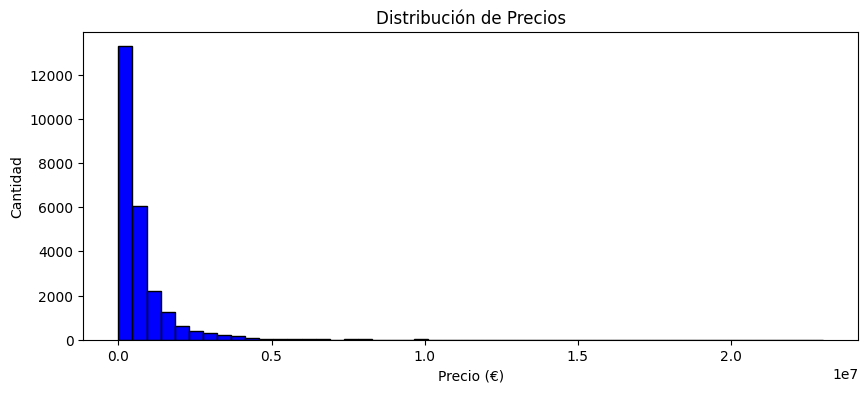

In [12]:
plt.figure(figsize=(10,4))
plt.hist(df['price'], bins=50, color='blue', edgecolor='black')
plt.title('Distribución de Precios')
plt.xlabel('Precio (€)')
plt.ylabel('Cantidad')
plt.show()

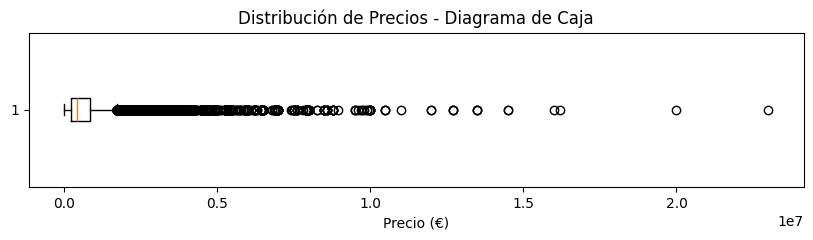

In [13]:
plt.figure(figsize=(10,2))
plt.boxplot(df['price'], vert=False)
plt.title('Distribución de Precios - Diagrama de Caja')
plt.xlabel('Precio (€)')
plt.show()

Límites para outliers de precio: -642500.00 - 1729500.00
Filas antes de eliminar outliers: 24822
Filas después de eliminar outliers: 22527
Se eliminaron 2295 filas (9.25%)


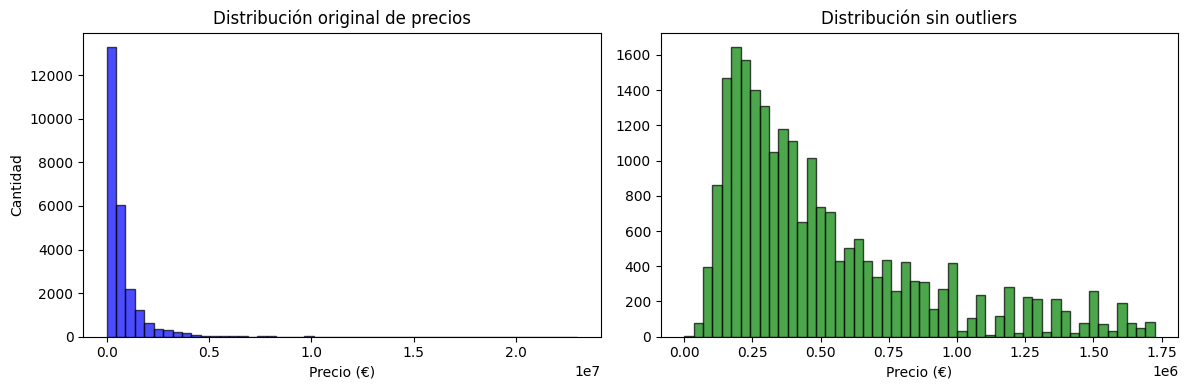

In [14]:
# Identificar y eliminar outliers de precio usando el método IQR (Rango Intercuartil)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para considerar outliers (usando 1.5 como factor estándar)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Límites para outliers de precio: {lower_bound:.2f} - {upper_bound:.2f}")
print(f"Filas antes de eliminar outliers: {len(df)}")

# Filtrar el dataframe para eliminar outliers
df2 = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Filas después de eliminar outliers: {len(df2)}")
print(f"Se eliminaron {len(df) - len(df2)} filas ({((len(df) - len(df2))/len(df)*100):.2f}%)")

# Visualizar distribución sin outliers
plt.figure(figsize=(12,4))

# Comparar histogramas: original vs sin outliers
plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribución original de precios')
plt.xlabel('Precio (€)')
plt.ylabel('Cantidad')

plt.subplot(1, 2, 2)
plt.hist(df2['price'], bins=50, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribución sin outliers')
plt.xlabel('Precio (€)')

plt.tight_layout()
plt.show()

# Actualizar el dataframe para análisis posteriores
df = df2.copy()